In [1]:
import torch
import matplotlib.pyplot as plt
import json
import os

In [2]:
torch.set_printoptions(precision=10)
PATH = "."

In [3]:
%run models/rendernet.py
%run data_loaders/scannet_render_loader.py

In [39]:
# Load a trained model using its best weights unless otherwise specified
def load_trained_model(train_id, checkpoint_name='model_best'):
    model_path = os.path.join(PATH, 'saved/models/DNR', train_id)

    # Load config file
    config_file = os.path.join(model_path, "config.json")
    if config_file:
        with open(config_file, 'r') as f:
            config = json.load(f)

    # Load model weights
    checkpoint_path = os.path.join(model_path, checkpoint_name) + '.pth'
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Handling loading of models from different versions will be tricky.
    # Eventually might need to check models out from git repo. For now,
    # use these fixes.
    if 'mipmap_levels' in config['arch']['args']:
        mipmap_levels = config['arch']['args']['mipmap_levels']
        print('contains mipmap:', mipmap_levels)
    else:
        mipmap_levels = 1
        checkpoint['state_dict']['neural_texture.mipmap.0'] = checkpoint['state_dict'].pop('neural_texture.texture')
        print('no mipmap:', mipmap_levels)
    
    # Load model with parameters from config file
    model = RenderNet(config['arch']['args']['texture_size'],
                     config['arch']['args']['texture_depth'],
                     mipmap_levels)
    
    # Assign model weights and set to eval (not train) mode
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    return model

In [40]:
# load all models by train id
def load_trained_models(train_ids):
    models = {}
    for train_id in train_ids:
        models[train_id] = load_trained_model(train_id)
    
    return models

In [41]:
# Cereate a libtorch script file containing the model that can be loaded into C++
def create_libtorch_script(model, train_id, checkpoint_name='model_best'):
    sm = torch.jit.script(model)
    model_script_name = 'DNR-{}-{}_model.pt'.format(train_id, checkpoint_name)
    model_script_path = os.path.join(PATH, 'libtorch-models', model_script_name)
    sm.save(model_script_path)
    print(model_script_path)

In [42]:
# Visualize a model prediction
def generate_images(model, test_input, tar):
    prediction = model(test_input)#, training=True)
    plt.figure(figsize=(20,20))
    
    _, h, w, c = test_input.shape
    test_input_color = torch.zeros((h, w, 3))#, dtype=type(test_input))
    test_input_color = test_input[:,:,:, 0]
    tar = tar.permute(0, 2, 3, 1)
    prediction = prediction.detach().permute(0, 2, 3, 1)

    display_list = [test_input_color[0].numpy(), tar[0].numpy(), prediction[0].numpy()]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [43]:
def generate_comparison(display_images, title, title_color):
    for i, image in enumerate(display_images):
        display_images[i] = image.permute(0, 2, 3, 1)
        
    # Should assert that rows * cols == len(title) == len(display_images)
    img_per_row = 2 # 3
    rows, cols = np.ceil(len(display_images) / img_per_row), np.min([len(display_images), img_per_row])
    plt.figure(figsize=(35 * cols,30 * rows))
    for i in range(len(display_images)):
        plt.subplot(rows, cols, i+1)
        plt.title(title[i], color=title_color[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_images[i][0].numpy() * 0.5 + 0.5)
        #plt.axis('off')
    plt.show()

In [144]:
def visualize_texture(mipmap, select=None):
    _, _, _, size = mipmap[0].shape
    sample = 0
    for i, texture in enumerate(mipmap):
        if select is not None and i != select:
            continue
        sample += F.interpolate(texture.detach(), size=size, mode='bilinear', align_corners=False)
    
    sample = sample[0,:,:,:]
    sample = sample.permute(1, 2, 0)
    
    height, width, channels = sample.shape
    
    
    plt.figure(figsize=(20, 20))
    for i in range(channels):
        plt.title('Channel {}'.format(i))
        plt.subplot(np.ceil(channels / 4), 4, i+1)
        plt.imshow(sample[:, :, i].numpy() * 0.5 + 0.5)
    plt.show()

In [73]:
##-- Execute code below --##

In [46]:
# List train ids here #
train_ids = ['0625_114333', '0626_000812', '0714_232542']
models = load_trained_models(train_ids)

no mipmap: 1
no mipmap: 1
contains mipmap: 4


1024


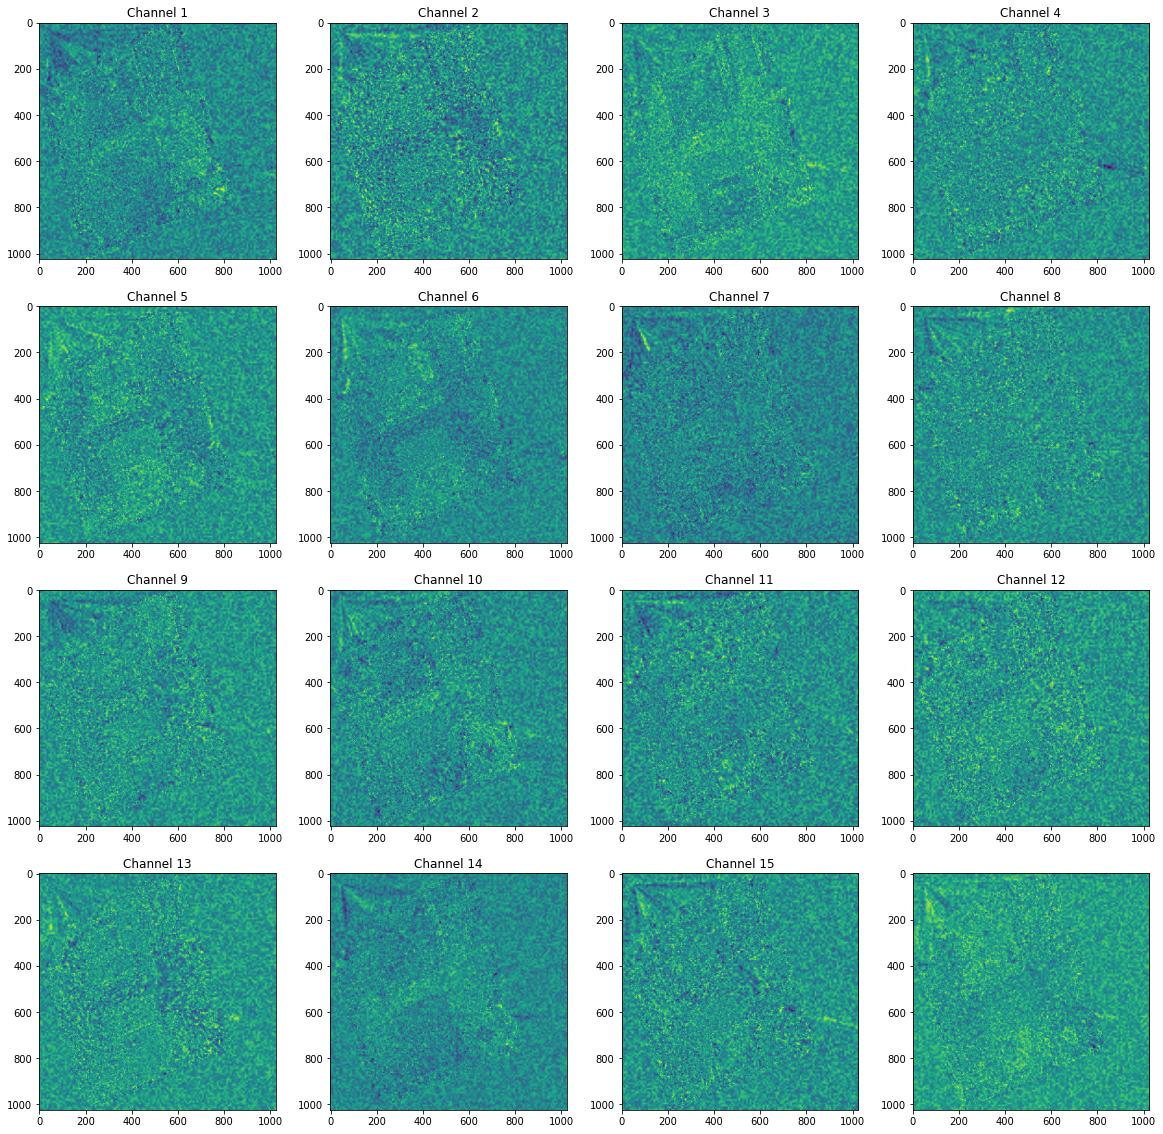

In [145]:
visualize_texture(models['0714_232542'].neural_texture.mipmap)
#visualize_texture(models['0626_000812'].neural_texture.mipmap, 1024)

3
Train ID: 0625_114333


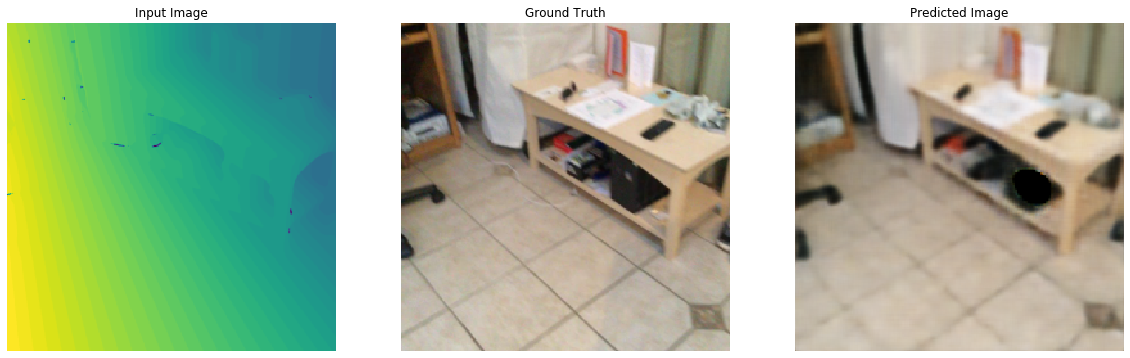

Train ID: 0626_000812


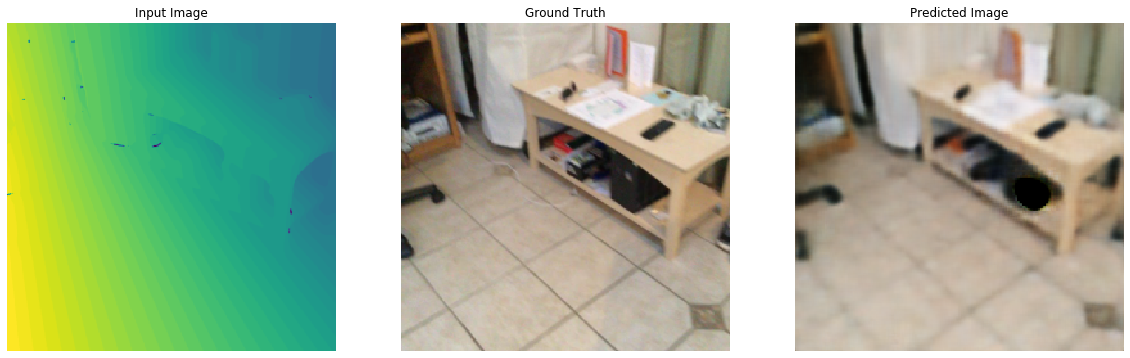

Train ID: 0714_232542


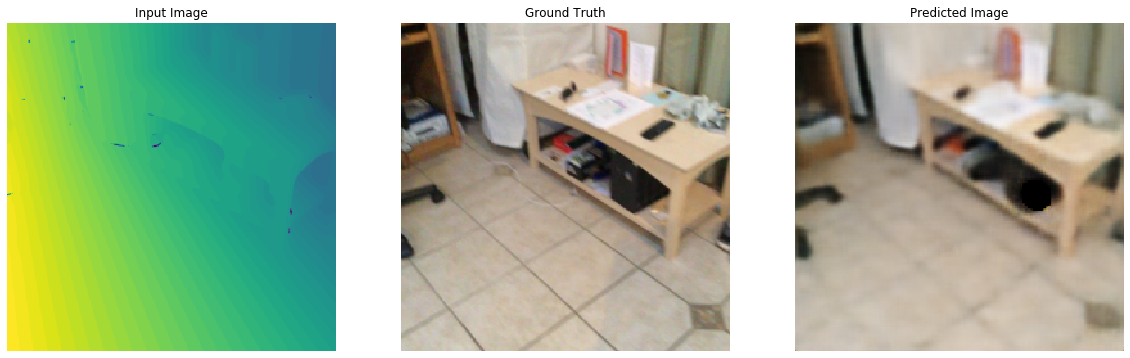

In [52]:
# Show a single validation input, ground truth and preducted sample from the first model #
print(len(train_ids))
loader = UVDataLoader('data', 1, True, 6).split_validation()#size=(256, 342))
for batch_idx, (data, target) in enumerate(loader):
    for train_id in train_ids:
        print('Train ID:', train_id)
        model = models[train_id]  
        generate_images(model, data, target)
    break

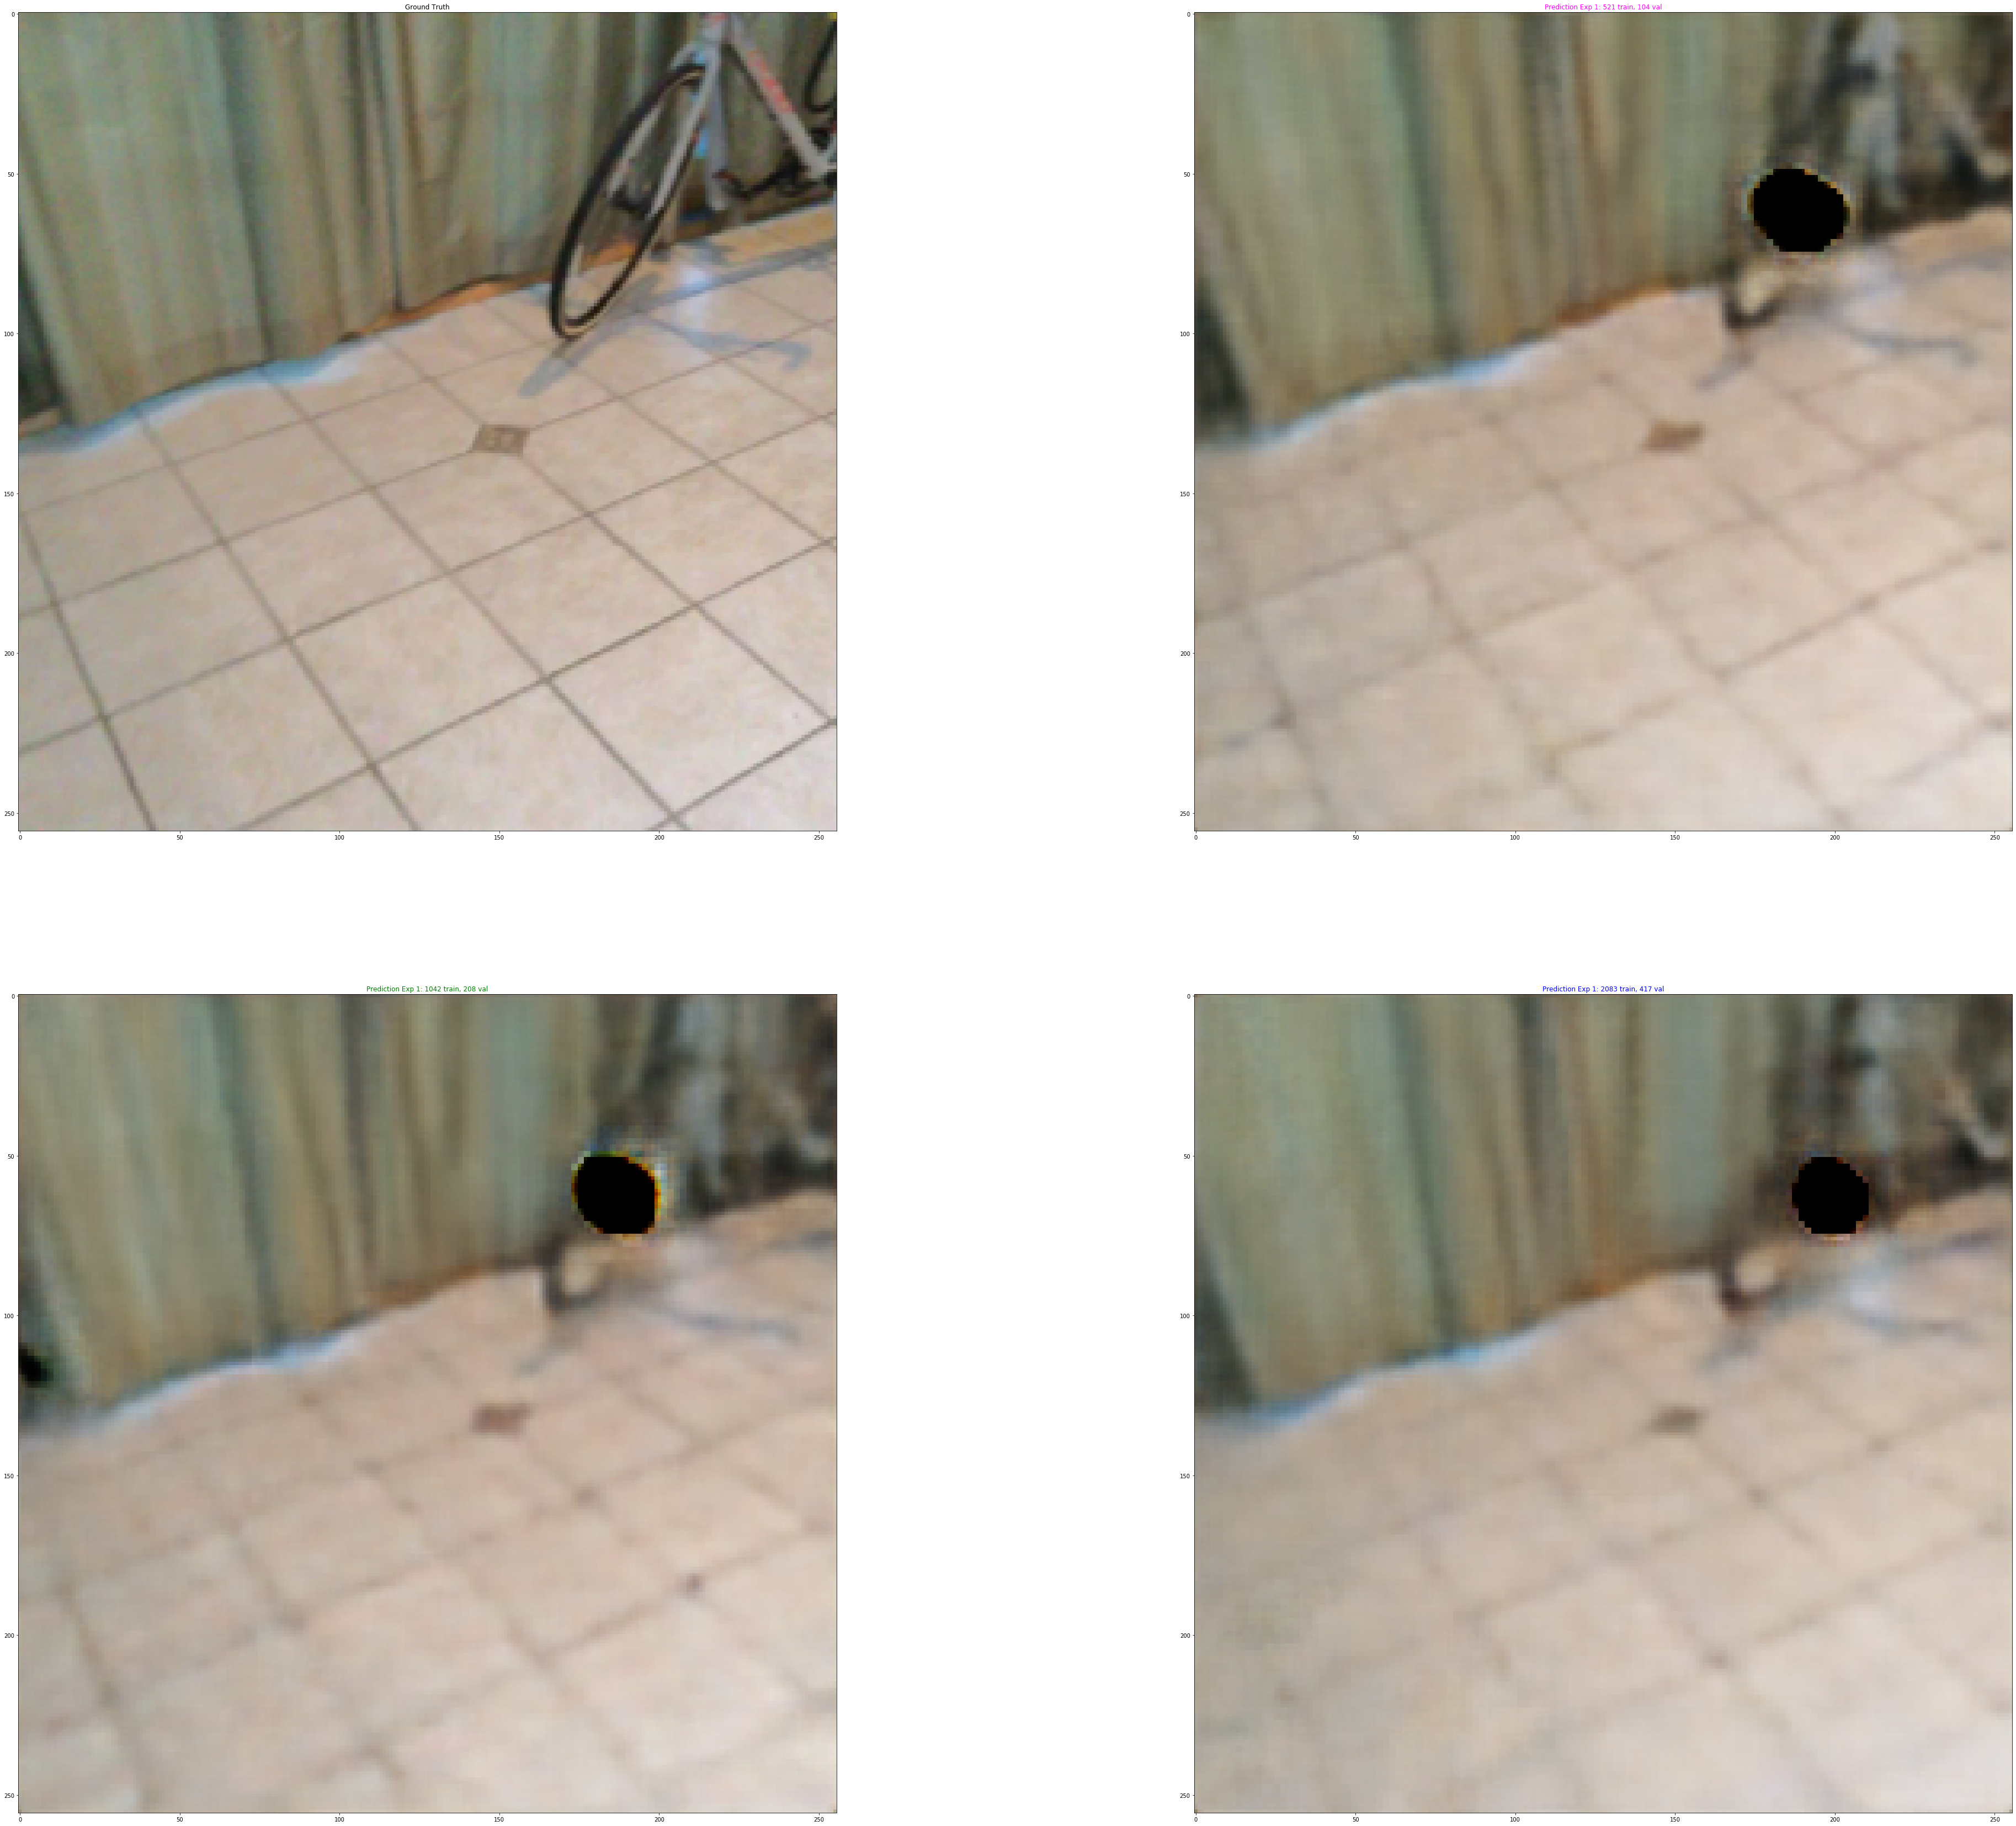

In [59]:
# Show a validation sample prediction for each model #

display_images = []
# Load from the validatiom dataset
loader = UVDataLoader('data', 1, True, 6).split_validation()
for batch_idx, (data, target) in enumerate(loader):
    # Add target image used to generate predictions
    display_images.append(target)

    # Add predictions
    for train_id in train_ids:
        # Get the trained model
        model = models[train_id]
        
        # Make a prediction using the model
        prediction = model(data)
        prediction = prediction.detach()
        display_images.append(prediction)
    break

# Plot results
title = ['Ground Truth', 'Prediction Exp 1: 521 train, 104 val',
         'Prediction Exp 1: 1042 train, 208 val',
         'Prediction Exp 1: 2083 train, 417 val']
title_color = ['black', 'magenta', 'green', 'blue']

generate_comparison(display_images, title, title_color)

In [57]:
# Create a libtorch script file from model #
train_id = '0626_000812'
print(train_id)
create_libtorch_script(models[train_id], train_id)

0626_000812


RuntimeError: 
Only constant Sequential, ModueList, or ModuleDict can be used as an iterable:
  File "/home/flynn/workspace/dnr/models/rendernet.py", line 59
        n_batches, _, _, _ = grid.shape
        sample = 0
        for texture in self.mipmap:
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~...  <--- HERE
            sample += F.grid_sample(texture.expand(n_batches, -1, -1, -1), grid, align_corners=False)
